In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()
import cv2, warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Add, Dropout, LSTM, TimeDistributed, Embedding, RepeatVector, Concatenate, Bidirectional, Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import InceptionV3  # Import InceptionV3 instead of ResNet50
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
img_path = r"C:\Users\SRAVAN\Downloads\RSICD_images\RSICD_images"
images = glob(img_path + '\\*.jpg')
images[:5]

captions = open(r"C:\Users\SRAVAN\Downloads\outcap.txt", 'rb').read().decode('utf-8').split('\n')
captions = [line.replace('\r', '') for line in captions]
captions[:5]

['image,caption',
 '00001.jpg,a football field with several buildiings surroudned .',
 '00001.jpg,a rectangular playground and many tall buildings surrounded .',
 '00001.jpg,many buildings and green trees are around a playground .',
 '00001.jpg,many buildings are in different blocks with many green trees and a playground .']

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels.h5: None -- [SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)

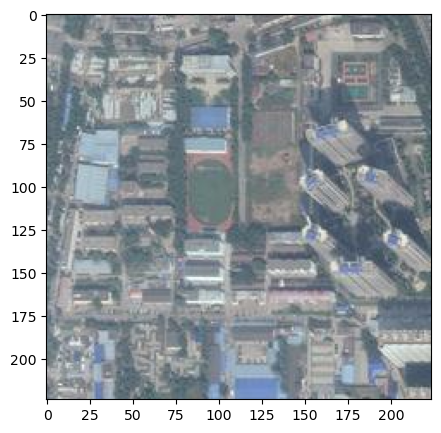

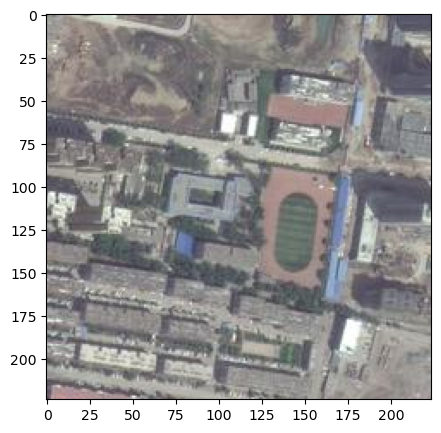

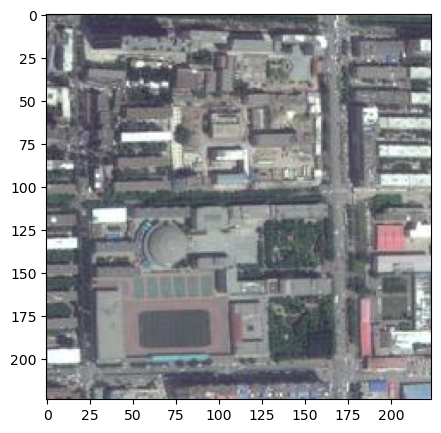

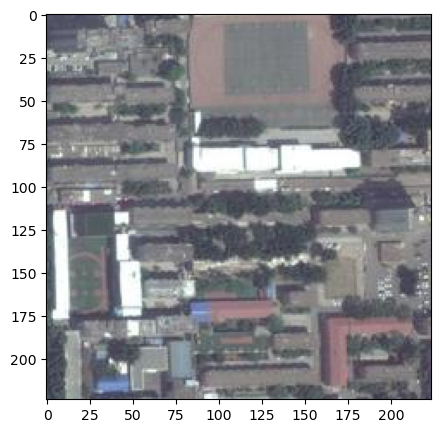

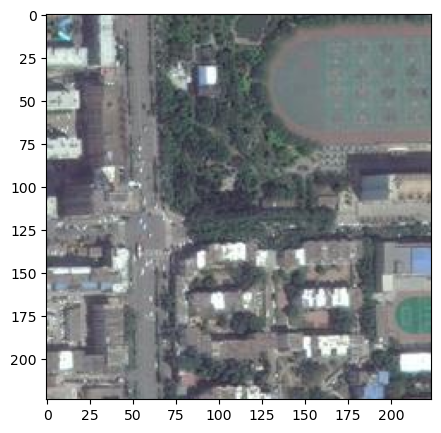

In [3]:
for i in range(5):
    plt.figure(figsize=(5,5))
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img);
    
inception_model = InceptionV3(include_top=True)  # Instantiate InceptionV3 model
inception_model.summary()

last = inception_model.layers[-2].output  # Output of the penultimate layer of InceptionV3 model
model = Model(inputs=inception_model.input,outputs=last)
model.summary()

In [ ]:
img_features = {}
count = 0

for img_path in tqdm(images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(299,299))  # InceptionV3 model requires images of dimensions (299, 299, 3)
    img = img.reshape(1,299,299,3)  # Reshaping image to the dimensions of a single image for InceptionV3
    features = model.predict(img).reshape(2048,)  # Feature extraction from images
    img_name = img_path.split('/')[-1]  # Extracting image name
    img_features[img_name] = features
    count += 1
    if count == 2000:
        break
    if count % 50 == 0:
        print(count)

In [ ]:
captions_dict = {}

for cap in captions:
    try:
        img_name = cap.split(',')[0]
        img_name = "C:\\Users\\SRAVAN\\Downloads\\RSICD_images\\RSICD_images\\"  + img_name  # Adding the prefix
        caption = cap.split(',')[1]
        
        if img_name in img_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]  # Storing the first caption
            else:
                captions_dict[img_name].append(caption)  # Adding the remaining captions 
    except:
        break

print(len(captions_dict))

In [ ]:
# Preprocess text
def text_preprocess(text):
    modified_text = text.lower()  # Converting text to lowercase
    modified_text = 'startofseq ' + modified_text + ' endofseq'  # Appending the special tokens at the beginning and ending of text
    return modified_text

# Storing the preprocessed text within the captions dictionary
for key, val in captions_dict.items():
    for item in val:
        captions_dict[key][val.index(item)] = text_preprocess(item)
        
count_words = dict()
cnt = 1

for key, val in captions_dict.items():  # Iterating through all images with keys as images and their values as 5 captions
    for item in val:  # Iterating through all captions for each image
        for word in item.split():  # Iterating through all words in each caption
            if word not in count_words:
                count_words[word] = cnt
                cnt += 1
                
# Encoding the text by assigning each word to its corresponding index in the vocabulary i.e. count_words dictionary
for key, val in captions_dict.items():
    for caption in val:
        encoded = []
        for word in caption.split():
            encoded.append(count_words[word])
        captions_dict[key][val.index(caption)] = encoded
        
# Determining the maximum possible length of text within the entire captions text corpus
max_len = -1

for key, value in captions_dict.items():
    for caption in value:
        if max_len < len(caption):
            max_len = len(caption)
            
vocab_size = len(count_words)  # Vocab size is the total number of words present in count_words dictionary


In [ ]:
def generator(img,caption):
    n_samples = 0
    X = []
    y_input = []
    y_output = []
    
    for key, val in caption.items(): 
        for item in val: 
            for i in range(1,len(item)):
                X.append(img[key])  # Appending the input image features
                input_seq = [item[:i]]  # Previously generated text to be used as input to predict the next word 
                output_seq = item[i]  # The next word to be predicted as output
                # Padding encoded text sequences to the maximum length
                input_seq = pad_sequences(input_seq,maxlen=max_len,padding='post',truncating='post')[0] 
                # One Hot encoding the output sequence with vocabulary size as the total no. of classes
                output_seq = to_categorical([output_seq],num_classes=vocab_size+1)[0]
                y_input.append(input_seq)
                y_output.append(output_seq)
    
    return X, y_input, y_output

In [ ]:
X, y_in, y_out = generator(img_features,captions_dict)

len(X), len(y_in), len(y_out)

In [ ]:
# Converting input and output into Numpy arrays for faster processing
X = np.array(X)
y_in = np.array(y_in,dtype='float64')
y_out = np.array(y_out,dtype='float64')
X.shape, y_in.shape, y_out.shape

In [ ]:
from keras.layers import Layer, Reshape,add


class CaptionsModel(Layer):
    def __init__(self, vocab_size, embedding_len, max_len):
        super(CaptionsModel, self).__init__()
        self.embedding = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=False)  # Adjust embedding output_dim
        self.lstm = LSTM(256)
        self.vocab_size = vocab_size

    def call(self, inputs):
        img_features, sentence_features = inputs
        embeddings = self.embedding(sentence_features)
        merged = Concatenate(axis=1)([img_features, embeddings])
        lstm_output = self.lstm(merged)
        return lstm_output

vocab_size = len(count_words)
max_length = max_len

input1 = Input(shape=(2048,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

captions_model = CaptionsModel(vocab_size, 256, max_length)
sentence_features = captions_model([img_features_reshaped, input2])

x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(units=1456, activation='softmax')(x)  # Adjust units parameter


final_model = Model(inputs=[input1, input2], outputs=output)
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
final_model.summary()

In [16]:
from sklearn.model_selection import train_test_split

# Splitting data into train, validation, and test sets
X_train, X_temp, y_in_train, y_in_temp, y_out_train, y_out_temp = train_test_split(X, y_in, y_out, test_size=0.6, random_state=42)
X_val, X_test, y_in_val, y_in_test, y_out_val, y_out_test = train_test_split(X_temp, y_in_temp, y_out_temp, test_size=0.5, random_state=42)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
mc = ModelCheckpoint(r'C:\Users\SRAVAN\Desktop\AI\Sem-6\Projects\DL\inception.keras', monitor='accuracy', verbose=1, mode='max', save_best_only=True)

# Compile the model with accuracy metric
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model with EarlyStopping and ModelCheckpoint callbacks
history = final_model.fit([X_train, y_in_train],
                          y_out_train,
                          batch_size=512,
                          callbacks=[mc, early_stopping],  # Remove ReduceLROnPlateau callback here
                          epochs=200,
                          validation_data=([X_val, y_in_val], y_out_val))

# Print loss, validation loss, and validation accuracy for each epoch
for epoch, metrics in enumerate(zip(history.history['loss'], history.history['val_loss'], history.history['val_accuracy'])):
    print(f"Epoch {epoch + 1}: loss: {metrics[0]:.4f} - val_loss: {metrics[1]:.4f} - val_accuracy: {metrics[2]:.4f}")

Epoch 1/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.0409 - loss: 7.3069
Epoch 1: accuracy improved from -inf to 0.05587, saving model to C:\Users\himas\Downloads\sem6_learning\dl&sip_project\dlsip2\model_implementation_2_5_may\inception_image_caption_generator.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 92s 819ms/step - accuracy: 0.0411 - loss: 7.2888 - val_accuracy: 0.0825 - val_loss: 4.3806
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.0798 - loss: 4.5292
Epoch 2: accuracy improved from 0.05587 to 0.08685, saving model to C:\Users\himas\Downloads\sem6_learning\dl&sip_project\dlsip2\model_implementation_2_5_may\inception_image_caption_generator.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 79s 797ms/step - accuracy: 0.0798 - loss: 4.5284 - val_accuracy: 0.1242 - val_loss: 4.1301
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.1307 - loss: 4.1972
Epoch 3: accuracy improved from 0.08685 to 0.14807, saving model to C:\Users\himas\Downloads\sem6_learning\dl&

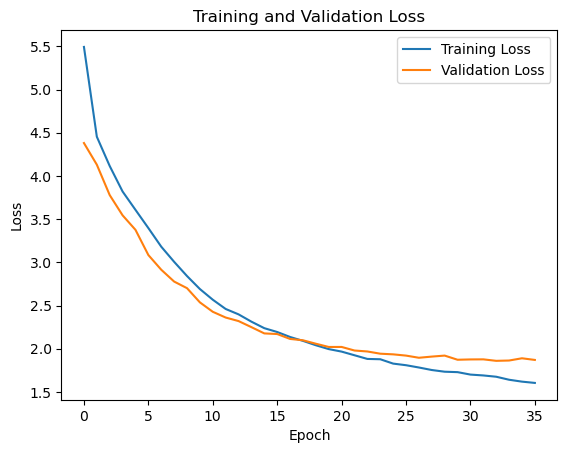

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Extracting training metrics
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# Extracting validation metrics
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Evaluating metrics on test set
test_loss, test_accuracy = final_model.evaluate([X_test, y_in_test], y_out_test, verbose=0)

# Printing metrics
print("Train Accuracy:", train_accuracy[-1])
print("Train Loss:", train_loss[-1])
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)
print("Validation Accuracy:", val_accuracy[-1])
print("Validation Loss:", val_loss[-1])

Train Accuracy: 0.5946263074874878
Train Loss: 1.6038365364074707
Test Accuracy: 0.5913119912147522
Test Loss: 1.8719072341918945
Validation Accuracy: 0.5937002301216125
Validation Loss: 1.8699840307235718


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Make predictions on the test set
y_pred = final_model.predict([X_test, y_in_test])

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_out_test, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
recall = recall_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)

f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
# Print evaluation metrics
print("Test Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


1178/1178 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step
Test Accuracy: 0.5913119912147522
Precision: 0.8966867311024689
Recall: 0.054745884720526466
F1 Score: 0.047641182296806216


In [21]:
def calculate_accuracy(model, X, y_in, y_out):
    predictions = model.predict([X, y_in])
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_out, axis=1)
    accuracy = np.mean(predicted_labels == true_labels)
    return accuracy

# Calculate accuracy on validation set
val_accuracy = calculate_accuracy(final_model, X_val, y_in_val, y_out_val)
print("Validation Accuracy:", val_accuracy)

# Calculate accuracy on test set
test_accuracy = calculate_accuracy(final_model, X_test, y_in_test, y_out_test)
print("Test Accuracy:", test_accuracy)

1178/1178 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step
Validation Accuracy: 0.593647171213247
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step
Test Accuracy: 0.5913119626366627


In [22]:
# Creating an inverse dictionary with reverse key-value pairs
inverse_dict = {val: key for key,val in count_words.items()}

In [23]:
​
Mettu Siddhartha
​
from tensorflow.keras.models import Sequential, model_from_json

# Assuming 'model' is already defined and trained

# Serialize model to JSON
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5 (with correct filename ending)
model.save_weights("CNN_model.weights.h5")
print("Saved model to disk")

In [24]:
np.save('vocab.npy',count_words)

In [25]:
# Custom function for extracting an image and transforming it into an appropriate format
def getImage(idx):
    test_img_path = images[idx]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(224,224))
    test_img = np.reshape(test_img,(1,224,224,3))
    return test_img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
BLEU-1 score: 33.33333333333333
BLEU-2 score: 15.430334996209186
BLEU-3 score: 8.091549842904573e-102
BLEU-4 score: 5.859491021246916e-153
Real Caption: two big playground and a small playground are surrounded by many buildings .
Predicted Caption:  a bridge is on a river with many buildings on two sides of it .


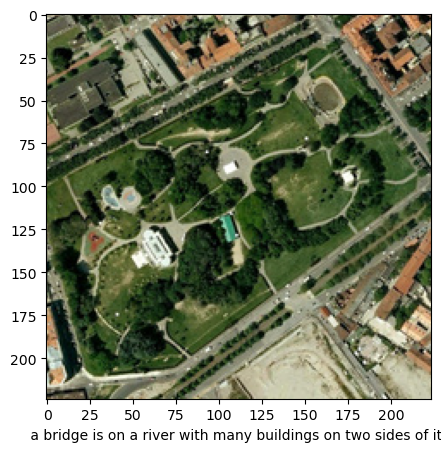

In [27]:
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously

# Process only the first image (index 0)
test_img_path = r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\park_106.jpg"  # Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = model.predict(getImage(image_index)).reshape(1,2048 )

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = "two big playground and a small playground are surrounded by many buildings ."

# Calculate BLEU scores
real_tokens = real_caption.split()
pred_tokens = caption.split()
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
BLEU-1 score: 60.63657586001313
BLEU-2 score: 44.96928821556907
BLEU-3 score: 38.30446313291742
BLEU-4 score: 27.664567170204542
Real Caption: two big playground and a small playground are surrounded by many buildings .
Predicted Caption:  a playground is surrounded by many buildings and many buildings .


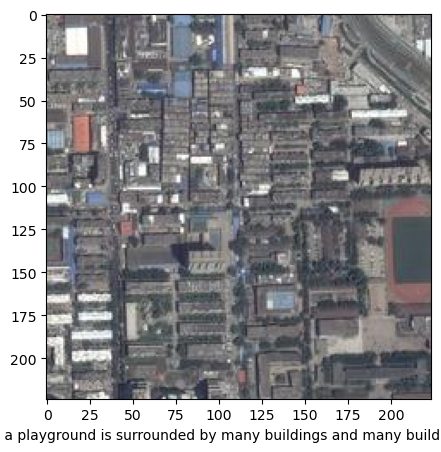

In [29]:
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously

# Process only the first image (index 0)
test_img_path = r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\00028.jpg"  # Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = "two big playground and a small playground are surrounded by many buildings ."

# Calculate BLEU scores
real_tokens = real_caption.split()
pred_tokens = caption.split()
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
BLEU-1 score: 18.181818181818183
BLEU-2 score: 6.360494346864464e-153
BLEU-3 score: 4.481692526548904e-204
BLEU-4 score: 1.1896457329133972e-229
Real Caption: six storagetanks by white material round into .
Predicted Caption:  a playground is surrounded by many buildings and many buildings .


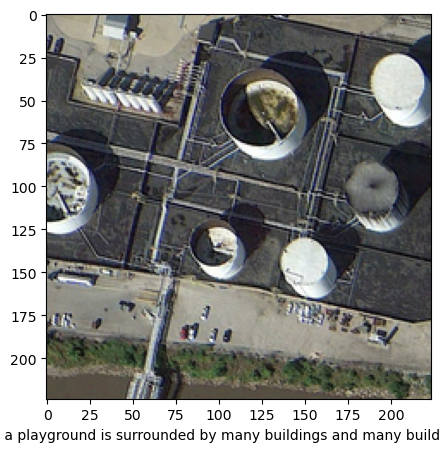

In [30]:
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None
    
# Process only the first image (index 0)
test_img_path = r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\storagetanks_103.jpg"  # Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "storagetanks_103.jpg")
# Calculate BLEU scores
real_tokens = real_caption.split()
pred_tokens = caption.split()
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
BLEU-1 score: 18.181818181818183
BLEU-2 score: 6.360494346864464e-153
BLEU-3 score: 4.481692526548904e-204
BLEU-4 score: 1.1896457329133972e-229
Real Caption: six storagetanks by white material round into .
Predicted Caption:  a playground is surrounded by many buildings and many buildings .


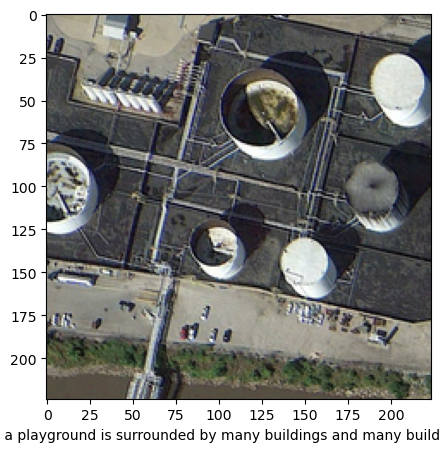

ROUGE Scores: {'rouge1': Score(precision=0.1, recall=0.14285714285714285, fmeasure=0.11764705882352941), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1, recall=0.14285714285714285, fmeasure=0.11764705882352941)}
METEOR score: 12.048192771084338


In [31]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path = r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\storagetanks_103.jpg"  # Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "storagetanks_103.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
BLEU-1 score: 30.326532985631673
BLEU-2 score: 6.397495320955232e-153
BLEU-3 score: 3.808369234528494e-204
BLEU-4 score: 9.291879812217675e-230
Real Caption: many cars and a circle road are around a circle stadium .
Predicted Caption:  a baseball field is near a road .


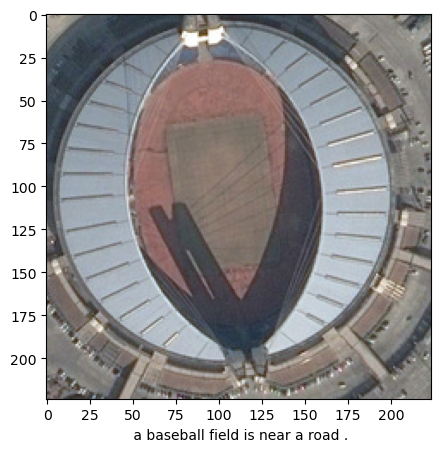

ROUGE Scores: {'rouge1': Score(precision=0.42857142857142855, recall=0.2727272727272727, fmeasure=0.33333333333333326), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2857142857142857, recall=0.18181818181818182, fmeasure=0.2222222222222222)}
METEOR score: 17.241379310344826


In [32]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path = r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\stadium_13.jpg"  # Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "stadium_13.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
BLEU-1 score: 35.294117647058826
BLEU-2 score: 14.852213144650115
BLEU-3 score: 7.888157848108797e-102
BLEU-4 score: 5.74867560479262e-153
Real Caption: the oil tanker is equipped with a large number of oil tanks in the dark .
Predicted Caption:  a piece of green ocean is near 

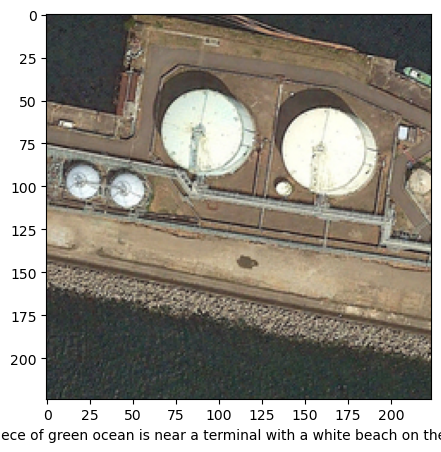

ROUGE Scores: {'rouge1': Score(precision=0.3125, recall=0.3333333333333333, fmeasure=0.3225806451612903), 'rouge2': Score(precision=0.06666666666666667, recall=0.07142857142857142, fmeasure=0.0689655172413793), 'rougeL': Score(precision=0.25, recall=0.26666666666666666, fmeasure=0.2580645161290323)}
METEOR score: 26.483781918564524


In [33]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path =r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\storagetanks_307.jpg" # Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "storagetanks_307.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
BLEU-1 score: 45.45454545454545
BLEU-2 score: 30.15113445777636
BLEU-3 score: 21.616643908267598
BLEU-4 score: 3.8719283242189534e-76
Real Caption: many buildings and green plants are in a school .
Predicted Caption:  a playground is surrounded by many buildings and many buildings .


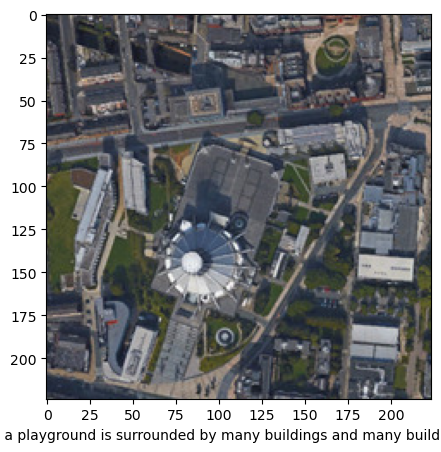

ROUGE Scores: {'rouge1': Score(precision=0.4, recall=0.4444444444444444, fmeasure=0.4210526315789474), 'rouge2': Score(precision=0.2222222222222222, recall=0.25, fmeasure=0.23529411764705882), 'rougeL': Score(precision=0.3, recall=0.3333333333333333, fmeasure=0.3157894736842105)}
METEOR score: 36.831683168316836


In [34]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path =r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\school_81.jpg" # Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "school_81.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
BLEU-1 score: 25.0
BLEU-2 score: 7.458340731200295e-153
BLEU-3 score: 4.983597475548963e-204
BLEU-4 score: 1.2882297539194153e-229
Real Caption: many of the planes were docked on the wide .
Predicted Caption:  many planes are parked in an airport near a parking lot .


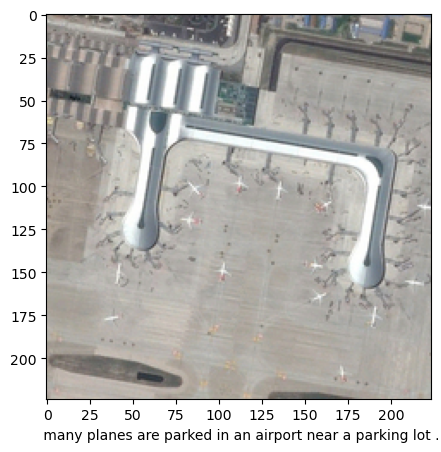

ROUGE Scores: {'rouge1': Score(precision=0.18181818181818182, recall=0.2222222222222222, fmeasure=0.19999999999999998), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.18181818181818182, recall=0.2222222222222222, fmeasure=0.19999999999999998)}
METEOR score: 14.705882352941178


In [35]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path =r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\airport_30.jpg" # Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "airport_30.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
BLEU-1 score: 18.75
BLEU-2 score: 6.459112543299825e-153
BLEU-3 score: 4.527898799603134e-204
BLEU-4 score: 1.198832868637291e-229
Real Caption: the twisty river is across the green rolling country .
Predicted Caption:  a baseball field is near a river with many buildings on two sides of it .


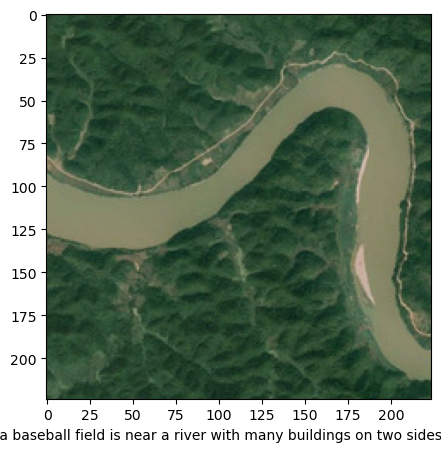

ROUGE Scores: {'rouge1': Score(precision=0.13333333333333333, recall=0.2222222222222222, fmeasure=0.16666666666666669), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06666666666666667, recall=0.1111111111111111, fmeasure=0.08333333333333334)}
METEOR score: 14.150943396226412


In [36]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path =r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\river_43.jpg"# Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature =model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "river_43.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
BLEU-1 score: 13.333333333333334
BLEU-2 score: 5.4468019467172e-153
BLEU-3 score: 4.041499534789231e-204
BLEU-4 score: 1.1008876702055895e-229
Real Caption: rails getting out of the huge gray rectangular ceiling are into confluence area .
Predicted Caption:  a bridge is on a river with many buildings on two sides of it .


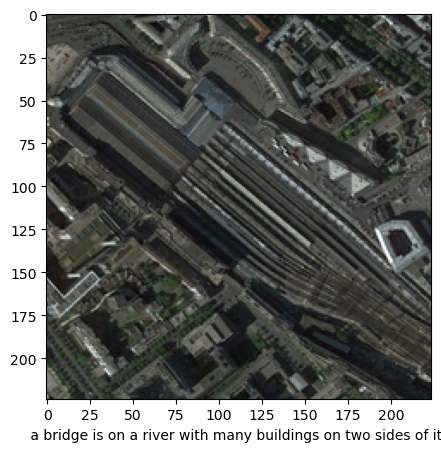

ROUGE Scores: {'rouge1': Score(precision=0.07142857142857142, recall=0.07692307692307693, fmeasure=0.07407407407407408), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07142857142857142, recall=0.07692307692307693, fmeasure=0.07407407407407408)}
METEOR score: 7.092198581560282


In [37]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path =r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\railwaystation_58.jpg"# Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "railwaystation_58.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
BLEU-1 score: 38.60923948807605
BLEU-2 score: 21.314325154497695
BLEU-3 score: 14.200689856546255
BLEU-4 score: 2.7383974845074875e-76
Real Caption: the pond next to a piece of white land is like a face of the british man .
Predicted Caption:  a playground is next to a river with many buildings on two sides of it .

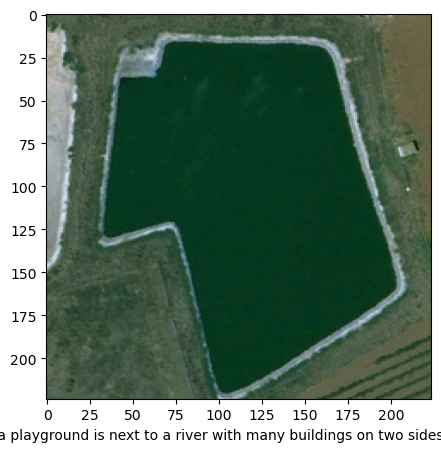

ROUGE Scores: {'rouge1': Score(precision=0.4, recall=0.35294117647058826, fmeasure=0.37500000000000006), 'rouge2': Score(precision=0.14285714285714285, recall=0.125, fmeasure=0.13333333333333333), 'rougeL': Score(precision=0.26666666666666666, recall=0.23529411764705882, fmeasure=0.25)}
METEOR score: 35.46348314606741


In [38]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path =r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\pond_412.jpg"# Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "pond_412.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
BLEU-1 score: 33.09363384692233
BLEU-2 score: 8.061224930331203e-153
BLEU-3 score: 5.034463925687666e-204
BLEU-4 score: 1.258141043412406e-229
Real Caption: it is a large piece of green mountain .
Predicted Caption:  a playground is surrounded by many buildings .


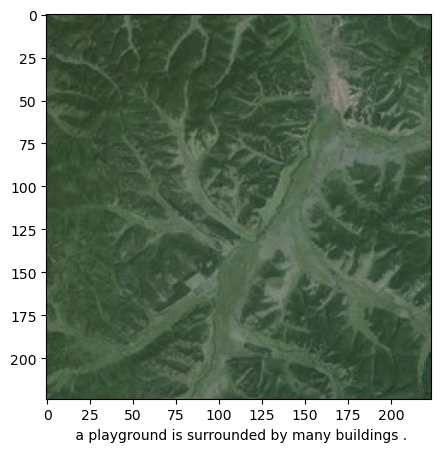

ROUGE Scores: {'rouge1': Score(precision=0.2857142857142857, recall=0.25, fmeasure=0.26666666666666666), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.14285714285714285, recall=0.125, fmeasure=0.13333333333333333)}
METEOR score: 16.853932584269664


In [39]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path =r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\mountain_120.jpg"# Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "mountain_120.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
BLEU-1 score: 46.15384615384615
BLEU-2 score: 27.735009811261456
BLEU-3 score: 19.12293963810262
BLEU-4 score: 3.531848763573142e-76
Real Caption: it is a piece of light green meadow .
Predicted Caption:  a piece of green ocean is near a piece of yellow beach .


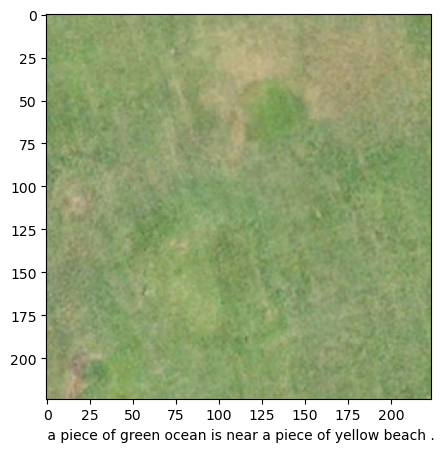

ROUGE Scores: {'rouge1': Score(precision=0.4166666666666667, recall=0.625, fmeasure=0.5), 'rouge2': Score(precision=0.18181818181818182, recall=0.2857142857142857, fmeasure=0.2222222222222222), 'rougeL': Score(precision=0.3333333333333333, recall=0.5, fmeasure=0.4)}
METEOR score: 54.37352245862884


In [40]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path =r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\meadow_220.jpg"# Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature =model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "meadow_220.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
BLEU-1 score: 58.333333333333336
BLEU-2 score: 32.56694736394648
BLEU-3 score: 1.3313722846995514e-101
BLEU-4 score: 8.512570894324454e-153
Real Caption: yellow beach is near green ocean with white waves .
Predicted Caption:  a piece of ocean is near yellow beach and green trees .


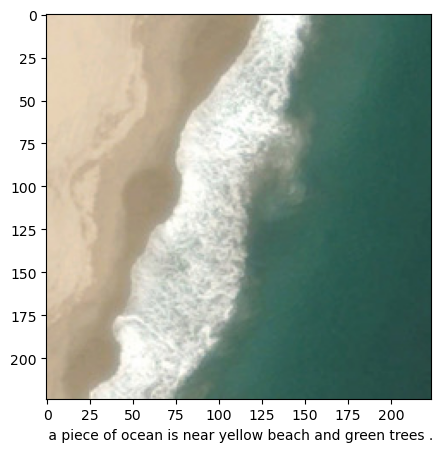

ROUGE Scores: {'rouge1': Score(precision=0.5454545454545454, recall=0.6666666666666666, fmeasure=0.6), 'rouge2': Score(precision=0.2, recall=0.25, fmeasure=0.22222222222222224), 'rougeL': Score(precision=0.2727272727272727, recall=0.3333333333333333, fmeasure=0.3)}
METEOR score: 56.12244897959183


In [41]:

from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path =r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\beach_31.jpg"# Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature =model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "beach_31.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
BLEU-1 score: 9.735009788392563
BLEU-2 score: 4.1072732976237013e-153
BLEU-3 score: 3.080533988057469e-204
BLEU-4 score: 8.436497969708995e-230
Real Caption: the industrial houses in the street are neatly arranged .
Predicted Caption:  a baseball field is near a road .


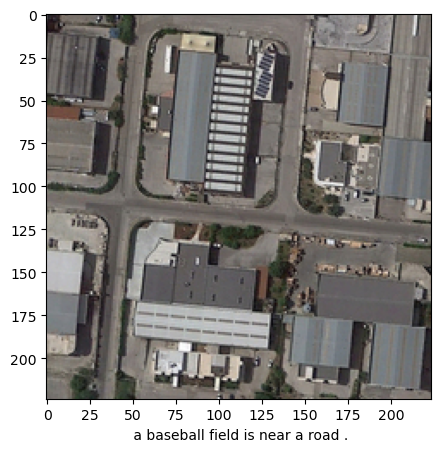

ROUGE Scores: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
METEOR score: 5.1020408163265305


In [42]:

from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path =r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\industrial_343.jpg"# Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "industrial_343.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
BLEU-1 score: 48.67504894196281
BLEU-2 score: 23.271124422474298
BLEU-3 score: 9.79043185931471e-102
BLEU-4 score: 6.350297761434924e-153
Real Caption: many buildings and cars are in an industrial area .
Predicted Caption:  many planes are parked in an airport .


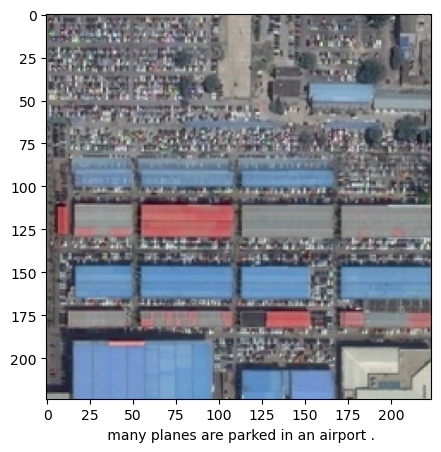

ROUGE Scores: {'rouge1': Score(precision=0.5714285714285714, recall=0.4444444444444444, fmeasure=0.5), 'rouge2': Score(precision=0.16666666666666666, recall=0.125, fmeasure=0.14285714285714288), 'rougeL': Score(precision=0.5714285714285714, recall=0.4444444444444444, fmeasure=0.5)}
METEOR score: 37.95918367346939


In [43]:

from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path =r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\industrial_12.jpg"# Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "industrial_12.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
BLEU-1 score: 18.181818181818183
BLEU-2 score: 6.360494346864464e-153
BLEU-3 score: 4.481692526548904e-204
BLEU-4 score: 1.1896457329133972e-229
Real Caption: to see a piece of green forest .
Predicted Caption:  a playground is surrounded by many buildings and many buildings .


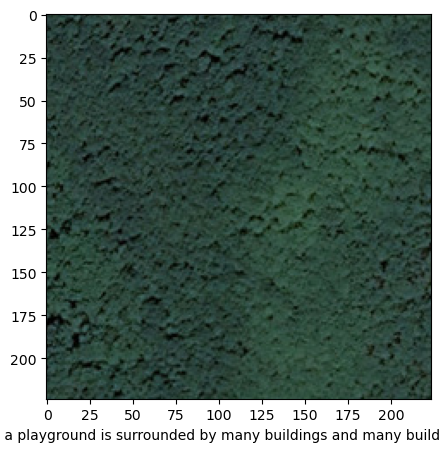

ROUGE Scores: {'rouge1': Score(precision=0.1, recall=0.14285714285714285, fmeasure=0.11764705882352941), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1, recall=0.14285714285714285, fmeasure=0.11764705882352941)}
METEOR score: 12.048192771084338


In [44]:

from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path =r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\forest_99.jpg"# Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "forest_99.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
BLEU-1 score: 18.181818181818183
BLEU-2 score: 6.360494346864464e-153
BLEU-3 score: 4.481692526548904e-204
BLEU-4 score: 1.1896457329133972e-229
Real Caption: several playgrounds is distributed in the different blocks .
Predicted Caption:  a playground is surrounded by many buildings and many buildings .


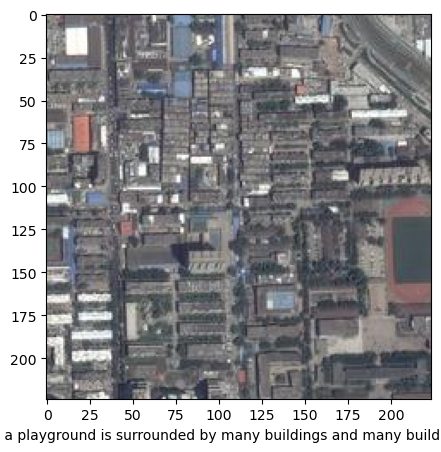

ROUGE Scores: {'rouge1': Score(precision=0.2, recall=0.25, fmeasure=0.22222222222222224), 'rouge2': Score(precision=0.1111111111111111, recall=0.14285714285714285, fmeasure=0.125), 'rougeL': Score(precision=0.2, recall=0.25, fmeasure=0.22222222222222224)}
METEOR score: 27.777777777777775


In [45]:


from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path =r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\00028.jpg"# Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "00028.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
BLEU-1 score: 17.647058823529413
BLEU-2 score: 6.266259591476803e-153
BLEU-3 score: 4.4373164185049205e-204
BLEU-4 score: 1.1808001696991507e-229
Real Caption: a football field with several buildiings surroudned .
Predicted Caption:  a bridge is on a parking lot with a parking 

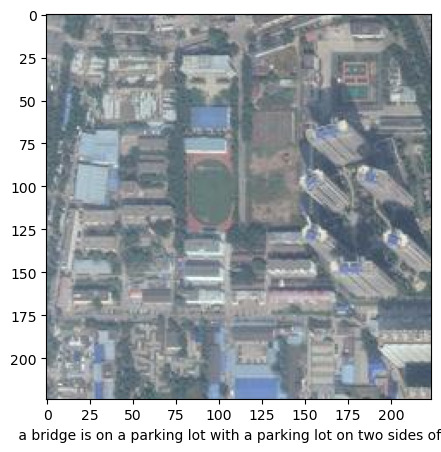

ROUGE Scores: {'rouge1': Score(precision=0.125, recall=0.2857142857142857, fmeasure=0.17391304347826086), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.125, recall=0.2857142857142857, fmeasure=0.17391304347826086)}
METEOR score: 16.85393258426966


In [46]:

from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path =r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\00001.jpg"# Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "00001.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
BLEU-1 score: 18.181818181818183
BLEU-2 score: 6.360494346864464e-153
BLEU-3 score: 4.481692526548904e-204
BLEU-4 score: 1.1896457329133972e-229
Real Caption: several playgrounds is distributed in the different blocks .
Predicted Caption:  a playground is surrounded by many buildings and many buildings .


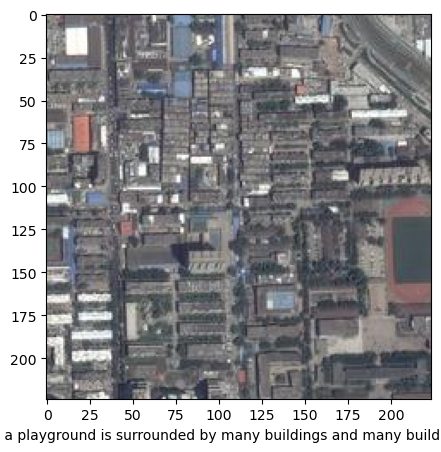

ROUGE Scores: {'rouge1': Score(precision=0.2, recall=0.25, fmeasure=0.22222222222222224), 'rouge2': Score(precision=0.1111111111111111, recall=0.14285714285714285, fmeasure=0.125), 'rougeL': Score(precision=0.2, recall=0.25, fmeasure=0.22222222222222224)}
METEOR score: 27.777777777777775


In [47]:
#00028.jpg

from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path =r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\00028.jpg"# Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "00028.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
BLEU-1 score: 16.666666666666668
BLEU-2 score: 6.08970970641905e-153
BLEU-3 score: 4.353573398748715e-204
BLEU-4 score: 1.1640469867513693e-229
Real Caption: river are twists and turns .
Predicted Caption:  many planes are parked in an airport with a parking lot .


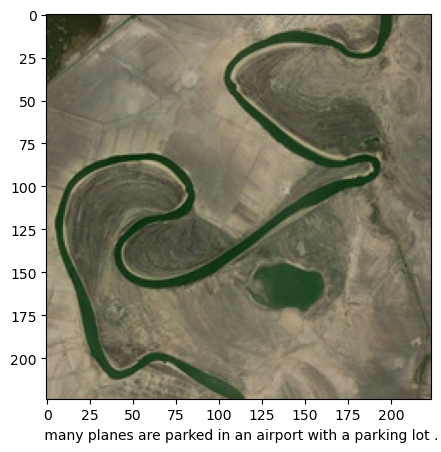

ROUGE Scores: {'rouge1': Score(precision=0.09090909090909091, recall=0.2, fmeasure=0.12500000000000003), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09090909090909091, recall=0.2, fmeasure=0.12500000000000003)}
METEOR score: 15.151515151515152


In [48]:

from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path =r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\river_87.jpg"# Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "river_87.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
BLEU-1 score: 60.13781189421007
BLEU-2 score: 42.08770096808336
BLEU-3 score: 27.275093103981362
BLEU-4 score: 4.1970648674788054e-76
Real Caption: many white planes are in an airport near some buildings .
Predicted Caption:  many planes are parked in an airport .


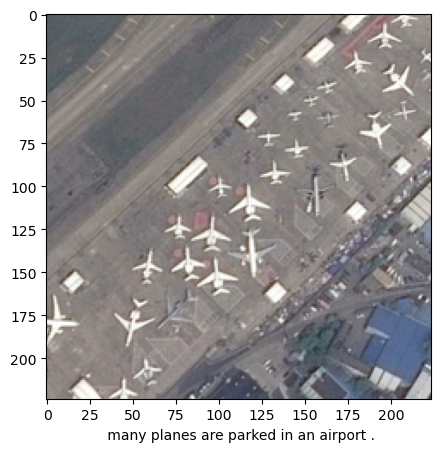

ROUGE Scores: {'rouge1': Score(precision=0.8571428571428571, recall=0.6, fmeasure=0.7058823529411764), 'rouge2': Score(precision=0.5, recall=0.3333333333333333, fmeasure=0.4), 'rougeL': Score(precision=0.8571428571428571, recall=0.6, fmeasure=0.7058823529411764)}
METEOR score: 59.317184817852365


In [49]:

from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path =r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\RSICD_images\airport_245.jpg"# Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature =model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", "airport_245.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


In [50]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Initialize lists to store scores
bleu1_scores = []
bleu2_scores = []
bleu3_scores = []
bleu4_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
meteor_scores = []

for i in range(10):  # Change this to the number of iterations you want
    random_no = np.random.randint(0, 1501, (1, 1))[0, 0]
    test_feature = model.predict(getImage(random_no)).reshape(1, 2048)
    test_img_path = images[random_no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    pred_text = ['startofseq']
    count = 0
    caption = ''  # Stores the predicted captions text

    while count < 25:
        count += 1
        # Encoding the captions text with numbers
        encoded = []

        for i in pred_text:
            encoded.append(count_words[i])

        encoded = [encoded]
        # Padding the encoded text sequences to maximum length
        encoded = pad_sequences(encoded, maxlen=max_len, padding='post', truncating='post')
        pred_idx = np.argmax(final_model.predict([test_feature, encoded]))  # Fetching the predicted word index having the maximum probability of occurrence
        sampled_word = inverse_dict[pred_idx]  # Extracting the predicted word by its respective index
        # Checking for ending of the sequence
        if sampled_word == 'endofseq':
            break
        caption = caption + ' ' + sampled_word
        pred_text.append(sampled_word)

    # Construct the real caption
    real_caption = read_captions(r"C:\Users\himas\Downloads\sem6_learning\dl&sip_project\UCM captions\RSICD_images\outcap.txt", test_img_path.split("\\")[-1])
    # Tokenize the real caption and predicted caption
    real_tokens = word_tokenize(real_caption)
    pred_tokens = word_tokenize(caption)
    
    # Calculate BLEU scores
    score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
    score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
    score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
    score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

    # Append BLEU scores to the lists
    bleu1_scores.append(score_bleu1)
    bleu2_scores.append(score_bleu2)
    bleu3_scores.append(score_bleu3)
    bleu4_scores.append(score_bleu4)
    
    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    # Calculate ROUGE scores
    scores_rouge = scorer.score(real_caption, caption)
    # Append ROUGE scores to the lists
    rouge1_scores.append(scores_rouge['rouge1'][2])
    rouge2_scores.append(scores_rouge['rouge2'][2])
    rougeL_scores.append(scores_rouge['rougeL'][2])
    
    # Calculate METEOR score
    score_meteor = meteor_score([real_tokens], pred_tokens)
    # Append METEOR score to the list
    meteor_scores.append(score_meteor)

# Calculate the average scores
average_bleu1_score = np.mean(bleu1_scores)
average_bleu2_score = np.mean(bleu2_scores)
average_bleu3_score = np.mean(bleu3_scores)
average_bleu4_score = np.mean(bleu4_scores)
average_rouge1_score = np.mean(rouge1_scores)
average_rouge2_score = np.mean(rouge2_scores)
average_rougeL_score = np.mean(rougeL_scores)
average_meteor_score = np.mean(meteor_scores)

# Print the average scores
print(f"Average BLEU-1 score: {average_bleu1_score * 100}")
print(f"Average BLEU-2 score: {average_bleu2_score * 100}")
print(f"Average BLEU-3 score: {average_bleu3_score * 100}")
print(f"Average BLEU-4 score: {average_bleu4_score * 100}")
print(f"Average ROUGE-1 score: {average_rouge1_score * 100}")
print(f"Average ROUGE-2 score: {average_rouge2_score * 100}")
print(f"Average ROUGE-L score: {average_rougeL_score * 100}")
print(f"Average METEOR score: {average_meteor_score * 100}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━